# Lead–Lag Network: Quick Example
This notebook demonstrates how to:
- Download prices for a set of tickers
- Build a lead–lag adjacency matrix and visualize the network
- Run the momentum strategy backtest driven by the network


In [1]:
# Safe inline plotting: works in Jupyter; harmless in plain Python
from IPython import get_ipython

_ip = get_ipython()
if _ip is not None:
    _ip.run_line_magic('matplotlib', 'inline')

import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from lead_lag_graph import build_adj, leadlag_graph
from trading_algo import backtest_network_momentum

# Plotting defaults
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 110


## 1) Download prices and compute daily log returns


In [2]:
tickers = [
    'SPY', 'QQQ', 'IWM', 'EFA', 'EEM',
    'TLT', 'IEF', 'SHY', 'LQD', 'HYG',
    'GLD', 'SLV', 'DBC', 'UUP', 'FXE',
]

# Adjust date range as desired
prices = yf.download(tickers, start='2007-01-01', end='2025-01-01')['Close'].dropna()
returns = np.log(prices / prices.shift(1)).dropna()
prices.tail(), returns.tail()


/var/folders/f9/1kf93kh165n3n2jnlj8q1f_m0000gn/T/ipykernel_49838/3451914235.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start='2007-01-01', end='2025-01-01')['Close'].dropna()
[*********************100%***********************]  15 of 15 completed


(Ticker            DBC        EEM        EFA        FXE         GLD        HYG  \
 Date                                                                            
 2024-12-24  21.040001  42.230888  74.568604  95.027870  241.440002  74.920563   
 2024-12-26  20.980000  42.082329  74.922478  95.334946  243.070007  75.111160   
 2024-12-27  21.080000  41.894150  74.814346  95.384483  241.399994  74.853851   
 2024-12-30  21.270000  41.557411  74.322861  95.136841  240.630005  74.958694   
 2024-12-31  21.379999  41.418755  74.322861  94.760422  242.130005  74.949150   
 
 Ticker            IEF         IWM         LQD         QQQ        SHY  \
 Date                                                                   
 2024-12-24  89.370323  221.646530  103.064011  527.965210  79.191208   
 2024-12-26  89.438156  223.918655  103.160324  527.606567  79.210587   
 2024-12-27  89.205627  220.654327  102.726898  520.593018  79.229958   
 2024-12-30  89.728775  218.957687  103.169960  513.669189 

## 2) Build and visualize the lead–lag network for the most recent window


HYG    1.025895
EFA    0.778604
IEF    0.573557
SPY    0.472034
TLT    0.466078
LQD    0.459182
SHY    0.378908
IWM    0.297520
EEM    0.053234
GLD    0.004324
Name: leader_z, dtype: float64

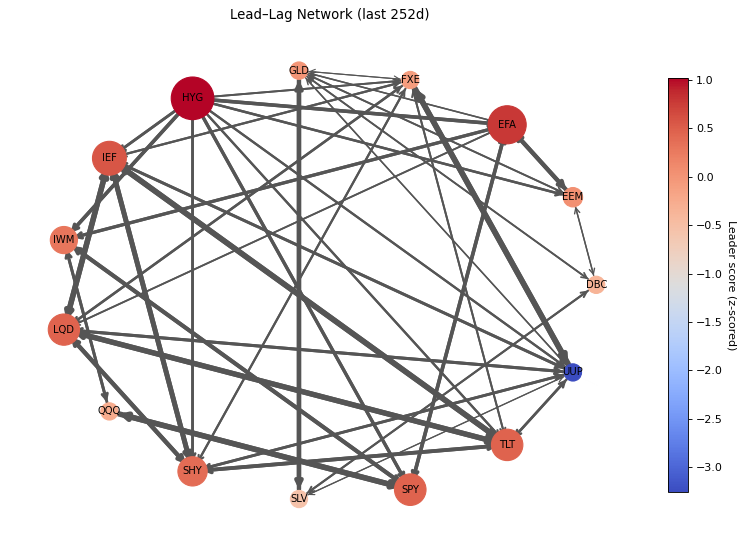

In [3]:
# Use the last 252 trading days to estimate the network
A = build_adj(returns.tail(252), max_lag=5, min_abs_corr=0.15)
H, z = leadlag_graph(
    A,
    title='Lead–Lag Network (last 252d)',
    max_edges=80,
    node_score='out_strength',
    layout='circular',
    seed=42,
    visualise=True,
)
# Top 10 leader z-scores
z.sort_values(ascending=False).head(10)


## 3) Run the network momentum backtest


In [4]:
port_rets, metrics, w_hist = backtest_network_momentum(
    prices, returns,
    leader_method="abs_out_strength",
    max_lag=5, min_abs_corr=0.15,
    sparsify_topk=3,
    regime="ma_cross", fast_ma=50, slow_ma=200,
    ema_span=15,
    target_ann_vol=0.10, cov_win=60, shrink_lambda=0.1,
    rebalance="W-FRI",
    use_numba=True
)
print(metrics)

{'CAGR': np.float64(0.05070218789261105), 'AnnVol': np.float64(0.09305721051394995), 'Sharpe': np.float64(0.5314869289150495), 'MaxDrawdown': -0.14665971695554614, 'NumTrades': 844, 'Start': '2008-04-15 00:00:00', 'End': '2024-12-31 00:00:00'}


## 4) Plot cumulative performance


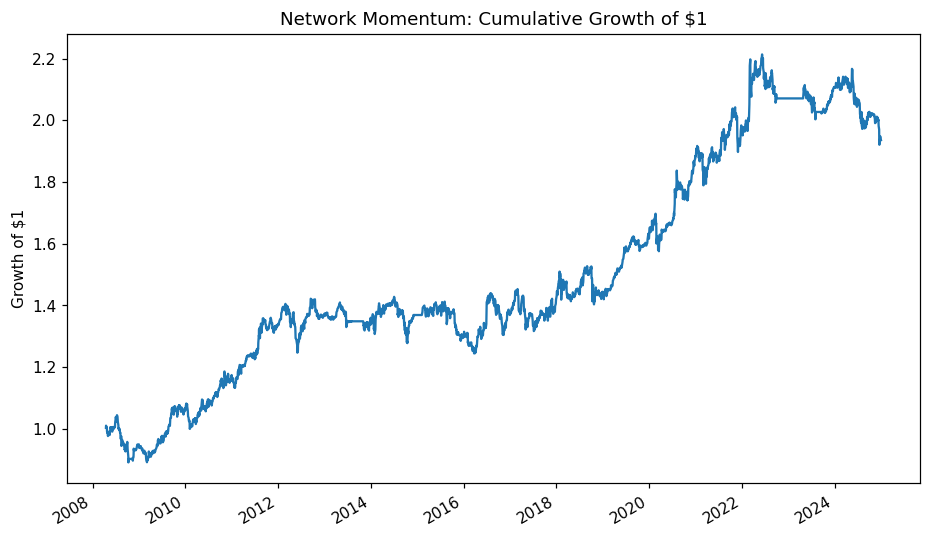

,DBC,EEM,EFA,FXE,GLD,HYG,IEF,IWM,LQD,QQQ,SHY,SLV,SPY,TLT,UUP
2024-11-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.480855,0.0,0.0,0.671528,0.0,0.0,0.0,0.0
2024-12-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.487462,0.0,0.0,0.680756,0.0,0.0,0.0,0.0
2024-12-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.504142,0.0,0.0,0.704049,0.0,0.0,0.0,0.0
2024-12-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.475352,0.0,0.0,0.298932,0.0,0.0,0.0,0.0
2024-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.475970,0.0,0.0,0.174632,0.0,0.0,0.0,0.0


In [5]:
cum = port_rets.cumsum().apply(np.exp)
ax = cum.plot(title='Network Momentum: Cumulative Growth of $1')
ax.set_ylabel('Growth of $1')
plt.show()

w_hist.tail()
